In [ ]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from net_properties_funcs import *
import datetime


In [2]:
chexnet = pickle.load(open("data/CHExNet.pkl", 'rb'))
time_id = pickle.load(open("data/time_id.pkl", 'rb'))
m_AUJ = chexnet["layer_1"]
m_BJ = chexnet["layer_2"]


# Exploration of aggregated structure
## First we load the networks in three facets, AUJ, BJ and Full

In [3]:
G_AUJ = nx.Graph()
e_AUJ = create_aggregated_network(m_AUJ)
G_AUJ.add_edges_from(e_AUJ)

G_BJ = nx.Graph()
e_BJ= create_aggregated_network(m_BJ)
G_BJ.add_edges_from(e_BJ)

G_full = nx.compose(G_AUJ, G_BJ)


## Now we create the visualizations


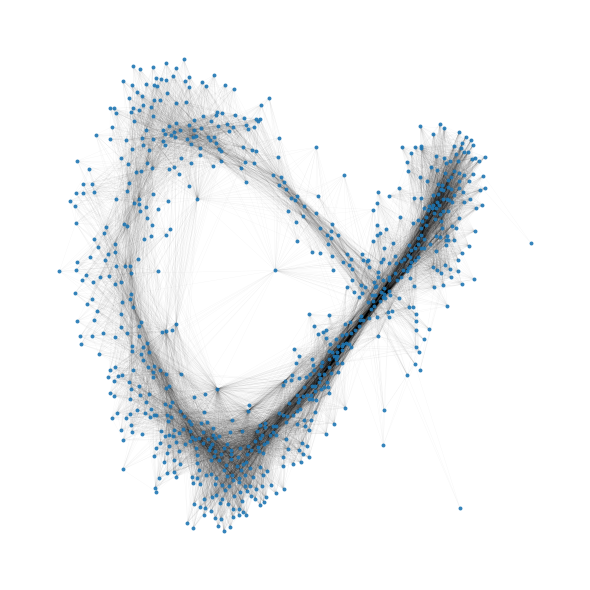

In [ ]:
### First for G_AUJ
pos = nx.spring_layout(G_AUJ, k=0.3, iterations=50, seed=42)  # more separation + more settle

plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(
    G_AUJ, pos,
    edge_color="k",
    width=0.2,
    alpha=0.05
)
nx.draw_networkx_nodes(
    G_AUJ, pos,
    node_size=8,
    node_color="#1f77b4",
    alpha=0.9,
    linewidths=0
)

plt.axis("off")
plt.tight_layout()
plt.savefig("network_auj.png", dpi=300, bbox_inches="tight")


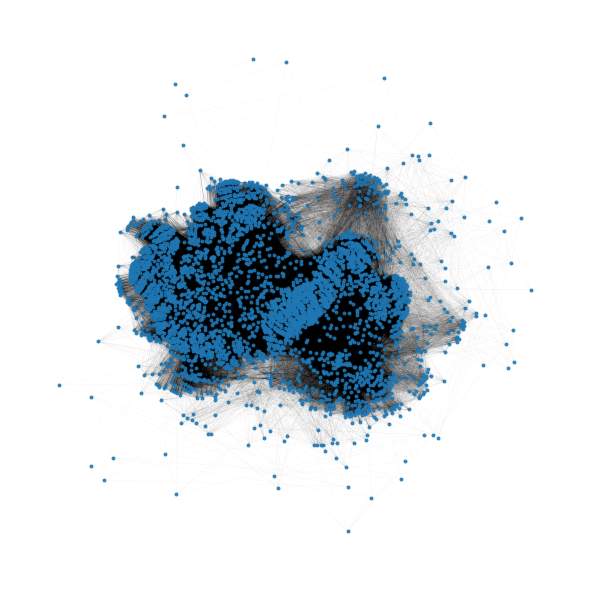

In [ ]:
### First for G_BJ

pos = nx.spring_layout(G_BJ, k=0.3, iterations=50, seed=42)  
plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(
    G_BJ, pos,
    edge_color="k",
    width=0.2,
    alpha=0.05
)
nx.draw_networkx_nodes(
    G_BJ, pos,
    node_size=8,
    node_color="#1f77b4",
    alpha=0.9,
    linewidths=0
)

plt.axis("off")
plt.tight_layout()
plt.savefig("network_bj.png", dpi=300, bbox_inches="tight")


In [ ]:
### First for G_full

pos = nx.spring_layout(G_full, k=0.3, iterations=50, seed=42)  # more separation + more settle
plt.figure(figsize=(6, 6))
nx.draw_networkx_edges(
    G_full, pos,
    edge_color="k",
    width=0.2,
    alpha=0.05
)
nx.draw_networkx_nodes(
    G_full, pos,
    node_size=10,
    node_color="#1f77b4",
    alpha=0.9,
    linewidths=0
)
plt.axis("off")
plt.tight_layout()
plt.savefig("network_full.png", dpi=300, bbox_inches="tight")


## Now we calculate metrics

In [ ]:

graphs = [("AUJ", G_AUJ), ("BJ", G_BJ), ("Full", G_full)]


graph_metrics_result = get_graph_metrics(graphs)
graph_metrics_result = graph_metrics_result.set_index("Metric").T.reset_index(names="Network")
graph_metrics_result.to_csv("results_graph_metrics.csv")

[('AUJ', <networkx.classes.graph.Graph object at 0x7f0998d181f0>), ('BJ', <networkx.classes.graph.Graph object at 0x7f0a4031d2a0>), ('Full', <networkx.classes.graph.Graph object at 0x7f0998d19390>)]


  0%|          | 0/9 [00:00<?, ?it/s]

Size (nodes)


 11%|█         | 1/9 [00:00<00:01,  4.61it/s]

Number of components


 22%|██▏       | 2/9 [00:00<00:03,  1.92it/s]

LCC size


 33%|███▎      | 3/9 [00:01<00:03,  1.64it/s]

LCC diameter


## Here we create the plot for temporal metrics

In [ ]:
dates = np.unique([datetime.date(year=x.year, month=1, day=1) for x in time_id.values() if x.year >= 1350 and x.year <= 1800])

G_BJs = [build_temporal_graph(m_BJ, t) for t in dates]
G_AUJs = [build_temporal_graph(m_AUJ, t) for t in dates]
G_fulls = [build_temporal_graph([m_BJ, m_AUJ], t) for t in dates]

In [ ]:

plt.figure(figsize=(5, 3.5))

ax = plt.subplot()
ax.plot(dates, [len(get_giant_component(x)) for x in G_BJs], label='BJ')
ax.plot(dates, [len(get_giant_component(x)) for x in G_AUJs], label='AUJ')
ax.plot(dates, [len(get_giant_component(x)) for x in G_fulls], label='Full')
ax.legend(frameon=False,loc='upper left')

# plt.legend()

ax.spines[['top', 'right']].set_visible(False)
plt.xlabel("Date")
plt.ylabel("Largest connected component size")
plt.tight_layout()
plt.savefig("connected_component.pdf", format="pdf")
plt.show()

In [ ]:

# --- metric (safe on empty/tiny graphs) ---
def avg_clust_safe(G):
    n = G.number_of_nodes()
    if n == 0:
        return np.nan          # no nodes -> undefined; use 0.0 if you prefer
    if n < 3:
        return 0.0             # triangles impossible with <3 nodes
    return nx.average_clustering(G, count_zeros=True)


clust_BJ   = parallel_series(G_BJs,   avg_clust_safe, desc="BJ avg_clust_safe")
clust_AUJ  = parallel_series(G_AUJs,  avg_clust_safe, desc="AUJ avg_clust_safe")
clust_full = parallel_series(G_fulls, avg_clust_safe, desc="Full avg_clust_safe")

# --- plot ---
plt.figure(figsize=(5, 3.5))
ax = plt.subplot()

ax.plot(dates, clust_BJ,   label="BJ")
ax.plot(dates, clust_AUJ,  label="AUJ")
ax.plot(dates, clust_full, label="Full")

ax.legend(frameon=False)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Date")
ax.set_ylabel("Average clustering")

plt.tight_layout()
plt.savefig("clustering_coefficient.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

def edge_density(G):
    n = G.number_of_nodes()
    if n <= 1:
        return np.nan
    m = G.number_of_edges()
    return 2*m / (n*(n-1))


dens_BJ   = parallel_series(G_BJs,   edge_density, desc="BJ edge_density")
dens_AUJ  = parallel_series(G_AUJs,  edge_density, desc="AUJ edge_density")
dens_full = parallel_series(G_fulls, edge_density, desc="Full edge_density")




plt.figure(figsize=(5, 3.5))
ax = plt.subplot()
ax.plot(dates, dens_BJ,   label="BJ")
ax.plot(dates, dens_AUJ,  label="AUJ")
ax.plot(dates, dens_full, label="Full")

ax.legend(frameon=False)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Date")
ax.set_ylabel("Edge density")
plt.tight_layout()
plt.savefig("edge_density.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
import networkx as nx

def n_components(G):
    n = G.number_of_nodes()
    if n == 0:
        return np.nan
    return nx.number_connected_components(G)

cc_BJ   = parallel_series(G_BJs,   n_components, desc="BJ #components")
cc_AUJ  = parallel_series(G_AUJs,  n_components, desc="AUJ #components")
cc_full = parallel_series(G_fulls, n_components, desc="Full #components")


# --- 1) Number of connected components ---
plt.figure(figsize=(5, 3.5))
ax = plt.subplot()
ax.plot(dates, cc_BJ,   label="BJ")
ax.plot(dates, cc_AUJ,  label="AUJ")
ax.plot(dates, cc_full, label="Full")
ax.set_ylabel("# connected components")
style_ax(ax)
plt.tight_layout()
plt.savefig("n_components.pdf", format="pdf", bbox_inches="tight")
plt.show()

/home/lvm/network_code/venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/home/lvm/network_code/venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/home/lvm/network_code/venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
BJ assortativity: 100%|██████████| 451/451 [00:13<00:00, 33.21it/s] 
/home/lvm/network_code/venv/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/home/l

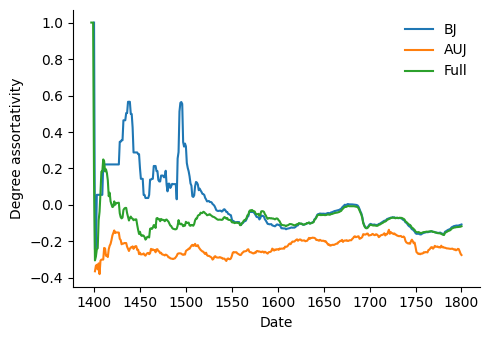

In [19]:
import networkx as nx

def deg_assort(G):
    # Assortativity is undefined/unstable for very small graphs or graphs with no edges
    if G.number_of_nodes() < 3 or G.number_of_edges() == 0:
        return np.nan
    return nx.degree_assortativity_coefficient(G)

r_BJ   = parallel_series(G_BJs,   deg_assort, desc="BJ assortativity")
r_AUJ  = parallel_series(G_AUJs,  deg_assort, desc="AUJ assortativity")
r_full = parallel_series(G_fulls, deg_assort, desc="Full assortativity")


# --- 2) Degree assortativity ---
plt.figure(figsize=(5, 3.5))
ax = plt.subplot()
ax.plot(dates, r_BJ,   label="BJ")
ax.plot(dates, r_AUJ,  label="AUJ")
ax.plot(dates, r_full, label="Full")
ax.set_ylabel("Degree assortativity")
style_ax(ax)
plt.tight_layout()
plt.savefig("degree_assortativity.pdf", format="pdf", bbox_inches="tight")
plt.show()

